In [1]:
import shapely
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly
import contextily as cx
import json
import shapely
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

In [5]:
blocks = pd.read_csv("../data/census_data_with_geo.csv", index_col=0)
blocks = gpd.GeoDataFrame(blocks, geometry = gpd.points_from_xy(blocks['longitude'], blocks['latitude']), crs="EPSG: 4326")
blocks

,geoid,name,median_age,white_pct,median_income,college_degree_pct,unemploy_pct,latitude,longitude,geometry
0,510010901011,"Block Group 1, Census Tract 901.01, Accomack C...",62.8,99.106145,60026.0,24.751861,0.000000,37.939472,-75.355340,POINT (-75.35534 37.93947)
1,510010901012,"Block Group 2, Census Tract 901.01, Accomack C...",50.3,94.311377,67121.0,23.396675,14.913958,37.922790,-75.369473,POINT (-75.36947 37.92279)
2,510010901021,"Block Group 1, Census Tract 901.02, Accomack C...",67.0,98.614610,43929.0,24.516575,12.970711,37.929723,-75.375450,POINT (-75.37545 37.92972)
3,510010901022,"Block Group 2, Census Tract 901.02, Accomack C...",30.3,86.363636,23990.0,24.920635,0.000000,37.914678,-75.391010,POINT (-75.39101 37.91468)
4,510010902011,"Block Group 1, Census Tract 902.01, Accomack C...",53.3,77.892031,31606.0,10.188088,6.435644,37.952117,-75.494588,POINT (-75.49459 37.95212)
...,...,...,...,...,...,...,...,...,...,...
5958,518400003014,"Block Group 4, Census Tract 3.01, Winchester c...",30.9,80.674342,NaN,9.587379,1.862464,39.170614,-78.173895,POINT (-78.17390 39.17061)
5959,518400003021,"Block Group 1, Census Tract 3.02, Winchester c...",30.6,73.770492,37105.0,16.845494,2.444703,39.157669,-78.179825,POINT (-78.17982 39.15767)
5960,518400003022,"Block Group 2, Census Tract 3.02, Winchester c...",47.6,76.758242,109412.0,33.167559,6.595538,39.155869,-78.191557,POINT (-78.19156 39.15587)
5961,518400003023,"Block Group 3, Census Tract 3.02, Winchester c...",36.2,88.027108,88500.0,19.151671,5.693431,39.147840,-78.185258,POINT (-78.18526 39.14784)


In [9]:
blocks = blocks.dropna()
blocks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5554 entries, 0 to 5962
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geoid               5554 non-null   int64   
 1   name                5554 non-null   object  
 2   median_age          5554 non-null   float64 
 3   white_pct           5554 non-null   float64 
 4   median_income       5554 non-null   float64 
 5   college_degree_pct  5554 non-null   float64 
 6   unemploy_pct        5554 non-null   float64 
 7   latitude            5554 non-null   float64 
 8   longitude           5554 non-null   float64 
 9   geometry            5554 non-null   geometry
dtypes: float64(7), geometry(1), int64(1), object(1)
memory usage: 477.3+ KB


In [12]:
hospitals = pd.read_csv("../data/Definitive_Healthcare__USA_Hospital_Beds.csv")
hospitals = gpd.GeoDataFrame(hospitals, geometry = gpd.points_from_xy(
    hospitals['x'], hospitals['y']), crs="EPSG: 4326")
hospitals

,x,y,objectid,hospital_name,hospital_type,hq_address,hq_address1,hq_city,hq_state,hq_zip_code,...,state_fips,cnty_fips,fips,num_licensed_beds,num_staffed_beds,num_icu_beds,bed_utilization,potential_increase_in_bed,geolocation,geometry
0,-78.469600,38.663800,3949,Page Memorial Hospital,Critical Access Hospital,200 Memorial Dr,NaN,Luray,VA,22835,...,51,139,51139,25.0,25.0,4,0.404384,0,POINT (-78.4696 38.6638),POINT (-78.46960 38.66380)
1,-78.914455,36.712479,3936,Sentara Halifax Regional Hospital,Short Term Acute Care Hospital,2204 Wilborn Ave,NaN,South Boston,VA,24592,...,51,83,51083,192.0,107.0,12,0.373166,85,POINT (-78.91445539999995 36.71247910000005),POINT (-78.91446 36.71248)
2,-76.246118,36.746132,3968,Chesapeake Regional Medical Center (AKA Chesap...,Short Term Acute Care Hospital,736 Battlefield Blvd N,NaN,Chesapeake,VA,23320,...,51,550,51550,310.0,310.0,28,0.614432,0,POINT (-76.24611819999996 36.74613160000007),POINT (-76.24612 36.74613)
3,-81.510226,36.831460,3957,Southwestern Virginia Mental Health Institute,Psychiatric Hospital,340 Bagley Cir,NaN,Marion,VA,24354,...,51,173,51173,109.0,109.0,0,0.725927,0,POINT (-81.51022649999999 36.83145980000006),POINT (-81.51023 36.83146)
4,-77.407014,37.540150,3989,Richmond Community Hospital,Short Term Acute Care Hospital,1500 N 28th St,NaN,Richmond,VA,23223,...,51,760,51760,104.0,101.0,5,0.274759,3,POINT (-77.40701409999997 37.54015040000007),POINT (-77.40701 37.54015)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-76.668537,37.250868,5758,Riverside Doctors Hospital Williamsburg,Short Term Acute Care Hospital,1500 Commonwealth Ave,NaN,Williamsburg,VA,23185,...,51,830,51830,40.0,40.0,10,0.337808,0,POINT (-76.66853719999995 37.25086760000005),POINT (-76.66854 37.25087)
120,-79.516200,37.352300,3966,Centra Bedford Memorial Hospital,Short Term Acute Care Hospital,1613 Oakwood St,NaN,Bedford,VA,24523,...,51,19,51019,50.0,34.0,6,0.410073,16,POINT (-79.5162 37.3523),POINT (-79.51620 37.35230)
121,-78.444465,38.022468,3917,Sentara Martha Jefferson Hospital,Short Term Acute Care Hospital,500 Martha Jefferson Dr,NaN,Charlottesville,VA,22911,...,51,3,51003,176.0,150.0,12,0.615160,26,POINT (-78.444465 38.02246790000004),POINT (-78.44446 38.02247)
122,-80.023684,37.276102,3993,Salem VA Medical Center,VA Hospital,1970 Roanoke Blvd,NaN,Salem,VA,24153,...,51,775,51775,NaN,NaN,1,NaN,0,POINT (-80.02368429999996 37.27610160000006),POINT (-80.02368 37.27610)


In [33]:
firestations = pd.read_csv("../data/Fire_Stations.csv")
firestations = gpd.GeoDataFrame(firestations, 
                                geometry=gpd.points_from_xy(x=firestations['X']/1e5, y=firestations['Y']/1e5),
                               crs = "EPSG: 4269")
firestations

,X,Y,OBJECTID,PERMANENT_IDENTIFIER,SOURCE_FEATUREID,SOURCE_DATASETID,SOURCE_DATADESC,SOURCE_ORIGINATOR,DATA_SECURITY,DISTRIBUTION_POLICY,...,ADDRESSBUILDINGNAME,ADDRESS,CITY,STATE,ZIPCODE,GNIS_ID,FOOT_ID,COMPLEX_ID,GLOBALID,geometry
0,-8902931.133,4479072.943,46,{14205455-F8A6-46D5-97AC-EB44232F26EE},NaN,{CC44F99C-6658-4584-B606-926E498D5C82},TNMC VWE DB Build - Vol Update,U.S. Geological Survey,5,E4,...,NaN,514 24th Street,Roanoke,VA,24017,NaN,NaN,NaN,{89EB6898-9956-4B51-8005-A3E72FEE9E40},POINT (-89.02931 44.79073)
1,-8950604.542,4468248.680,62,{89598BD0-319A-47A0-A306-BD019AA75D76},NaN,{CC44F99C-6658-4584-B606-926E498D5C82},TNMC VWE DB Build - Vol Update,U.S. Geological Survey,5,E4,...,NaN,407 Hubbard Street,Blacksburg,VA,24060,NaN,NaN,NaN,{077BE8DD-58FC-43CE-8815-C6EC51D8204F},POINT (-89.50605 44.68249)
2,-8650001.402,4622368.946,18453,{549E173D-4431-4DE4-AB10-CBF7D8E421A9},NaN,c49d87e5-a145-4cec-ae00-14715ea34eec,740 TNMC Update 1/8/2017,U.S. Geological Survey,5,E4,...,NaN,10501 Orange Plank Road,Spotsylvania,VA,22553,2075171.0,NaN,NaN,{53541B1C-7679-485E-B869-736F5E4678EE},POINT (-86.50001 46.22369)
3,-8627035.472,4621075.174,18463,c6200e19-8a51-4314-9d34-4688b9e0a529,VA000008,c49d87e5-a145-4cec-ae00-14715ea34eec,740 TNMC Update 1/8/2017,U.S. Geological Survey,5,E4,...,NaN,101 Altoona Drive,Fredericksburg,VA,22401,2331674.0,,NaN,{221CA597-14F9-4B5A-A713-0ACDDFC65C2E},POINT (-86.27035 46.21075)
4,-8636369.282,4617121.277,18484,{32FC30DE-631B-4FAE-895B-5F6BD558B701},NaN,c49d87e5-a145-4cec-ae00-14715ea34eec,740 TNMC Update 1/8/2017,U.S. Geological Survey,5,E4,...,NaN,11201 Gordon Road,Fredericksburg,VA,22407,2660618.0,NaN,NaN,{BFED7B6D-2C20-45DB-970A-8CF4687FFDB5},POINT (-86.36369 46.17121)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,-8557234.900,4569729.299,44986,6f39952e-18e6-42cc-99f9-275b35078b1b,VA000275,2a8f03a6-523e-4b6b-a2ea-2b811e8b19d1,740 TNMC Update 4/14/2019,U.S. Geological Survey,5,E4,...,NaN,620 Airport Road,Tappahannock,VA,22560,2075424.0,,NaN,{BAB5316B-1F57-4951-9C98-0B03AFAC8757},POINT (-85.57235 45.69729)
1005,-8478249.395,4427368.832,45040,4cd6a61b-0d6a-4c41-bee4-906568f2e9ce,NaN,3d09fc1b-4fb3-42bd-8897-ccb49db52a42,740 TNMC Update 3/21/2019,U.S. Geological Survey,0,E4,...,NaN,3848 Gator Blvd,Virginia Beach,VA,23455,NaN,NaN,NaN,{8DC98868-087A-4CBC-A59F-79BE871E215D},POINT (-84.78249 44.27369)
1006,-8461921.207,4476456.035,45065,{B17D6BA3-E48A-4C90-9E55-0F95E6729AC2},NaN,aade804d-1f7a-4e1a-a217-6d70fdf9e86f,740 TNMC Update 4/3/2019,U.S. Geological Survey,5,E4,...,NaN,501 Mason Avenue,Cape Charles,VA,23310,2086099.0,NaN,NaN,{14B9A92C-CA1A-4481-A478-F4EEC7750080},POINT (-84.61921 44.76456)
1007,-8737951.968,4579017.372,46719,{894F30DA-C142-480B-BB68-B261BE28755A},NaN,344d7956-1f63-4a2f-877d-c4f246db1347,740 TNMC Update 6/19/2019,U.S. Geological Survey,5,E4,...,NaN,1515 Founders Place,Charlottesville,VA,22902,2721059.0,NaN,NaN,{906699F9-3482-4C80-8D34-E7A87DA6905D},POINT (-87.37952 45.79017)


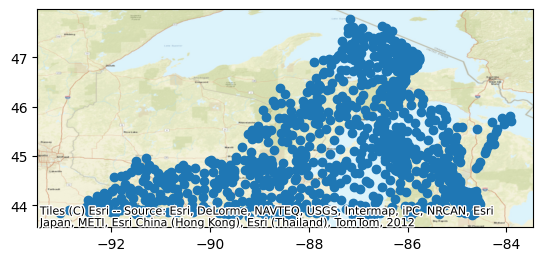

In [34]:
ax = firestations.plot()
cx.add_basemap(ax, crs=firestations.crs.to_string(), source = cx.providers.Esri.WorldStreetMap)

In [14]:
hospitals = hospitals.to_crs("EPSG:3857")
blocks = blocks.to_crs("EPSG:3857")

In [15]:
blocks.loc[:, "nearest_hospital_loc"] = blocks.geometry.apply(lambda geom: hospitals.geometry.distance(geom).idxmin())
blocks.loc[:, "nearest_hospital_dist"] = blocks.apply(lambda row: row.geometry.distance(
    hospitals.geometry.loc[row['nearest_hospital_loc']]), axis=1)
blocks

,geoid,name,median_age,white_pct,median_income,college_degree_pct,unemploy_pct,latitude,longitude,geometry,nearest_hospital_loc,nearest_hospital_dist
0,510010901011,"Block Group 1, Census Tract 901.01, Accomack C...",62.8,99.106145,60026.0,24.751861,0.000000,37.939472,-75.355340,POINT (-8388518.077 4570878.762),24,53015.236557
1,510010901012,"Block Group 2, Census Tract 901.01, Accomack C...",50.3,94.311377,67121.0,23.396675,14.913958,37.922790,-75.369473,POINT (-8390091.356 4568524.364),24,50307.412600
2,510010901021,"Block Group 1, Census Tract 901.02, Accomack C...",67.0,98.614610,43929.0,24.516575,12.970711,37.929723,-75.375450,POINT (-8390756.712 4569502.781),24,50415.219251
3,510010901022,"Block Group 2, Census Tract 901.02, Accomack C...",30.3,86.363636,23990.0,24.920635,0.000000,37.914678,-75.391010,POINT (-8392488.844 4567379.678),24,47725.304012
4,510010902011,"Block Group 1, Census Tract 902.01, Accomack C...",53.3,77.892031,31606.0,10.188088,6.435644,37.952117,-75.494588,POINT (-8404019.094 4572663.757),24,43706.552814
...,...,...,...,...,...,...,...,...,...,...,...,...
5957,518400003013,"Block Group 3, Census Tract 3.01, Winchester c...",32.1,48.504551,57575.0,13.573086,0.000000,39.172151,-78.168021,POINT (-8701624.294 4746360.811),19,4219.294256
5959,518400003021,"Block Group 1, Census Tract 3.02, Winchester c...",30.6,73.770492,37105.0,16.845494,2.444703,39.157669,-78.179825,POINT (-8702938.309 4744281.534),19,5430.095410
5960,518400003022,"Block Group 2, Census Tract 3.02, Winchester c...",47.6,76.758242,109412.0,33.167559,6.595538,39.155869,-78.191557,POINT (-8704244.310 4744023.126),19,5478.863122
5961,518400003023,"Block Group 3, Census Tract 3.02, Winchester c...",36.2,88.027108,88500.0,19.151671,5.693431,39.147840,-78.185258,POINT (-8703543.108 4742870.563),19,6688.870847


In [18]:
blocks['nearest_hospital_dist'].describe()

count     5554.000000
mean     10788.198237
std      10900.819024
min         65.302803
25%       3951.879719
50%       6864.291815
75%      12792.273773
max      93396.952102
Name: nearest_hospital_dist, dtype: float64

(array([3.592e+03, 1.040e+03, 4.270e+02, 2.620e+02, 1.440e+02, 6.600e+01,
        1.600e+01, 4.000e+00, 2.000e+00, 1.000e+00]),
 array([6.53028030e+01, 9.39846773e+03, 1.87316327e+04, 2.80647976e+04,
        3.73979625e+04, 4.67311275e+04, 5.60642924e+04, 6.53974573e+04,
        7.47306222e+04, 8.40637872e+04, 9.33969521e+04]),
 <BarContainer object of 10 artists>)

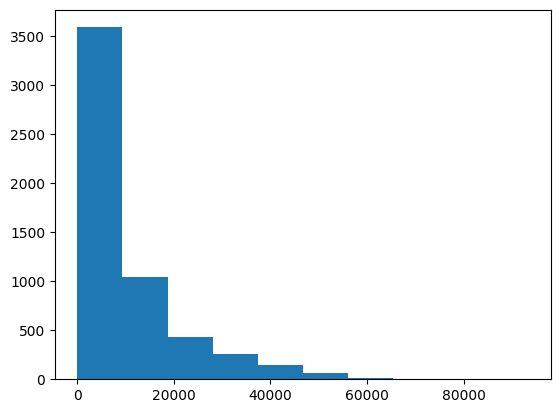

In [16]:
plt.hist(blocks['nearest_hospital_dist'])

In [20]:
import statsmodels.api as sm

In [21]:
blocks.columns

Index(['geoid', 'name', 'median_age', 'white_pct', 'median_income',
       'college_degree_pct', 'unemploy_pct', 'latitude', 'longitude',
       'geometry', 'nearest_hospital_loc', 'nearest_hospital_dist'],
      dtype='object')

In [22]:
X = blocks.loc[:, ['median_age', 'white_pct', 'median_income', 'college_degree_pct', 'unemploy_pct']]
y = blocks['nearest_hospital_dist']
X = sm.add_constant(X)
hospital_ols_model = sm.OLS(y, X)
hospital_ols_results = hospital_ols_model.fit()
hospital_ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     nearest_hospital_dist   R-squared:                       0.219
Model:                               OLS   Adj. R-squared:                  0.218
Method:                    Least Squares   F-statistic:                     310.5
Date:                   Tue, 07 Nov 2023   Prob (F-statistic):          5.87e-294
Time:                           22:25:29   Log-Likelihood:                -58828.
No. Observations:                   5554   AIC:                         1.177e+05
Df Residuals:                       5548   BIC:                         1.177e+05
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               3342.7280    703.094      4.754      0.000    1964.389    4721.067
median_age           182.9291     14.889     12.286      0.000     153.740     212.118
white_pct            112.5120      5.766     19.514      0.000     101.209     123.815
median_income          0.0038      0.004      0.986      0.324      -0.004       0.011
college_degree_pct  -337.5772     16.516    -20.440      0.000    -369.954    -305.200
unemploy_pct          -4.1332     24.741     -0.167      0.867     -52.635      44.369
==============================================================================
Omnibus:                     1996.881   Durbin-Watson:                   0.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8040.419
Skew:                           1.751   Prob(JB):                         0.00
Kurtosis:                       7.742   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""